## Introduction
**This notebook explains the implementation of the function "load_single_epoch" found in "functions.py"**

There exists many different types of geomagnetic data from different sources, e.g. ground and satellite and. In this modelling toolbox we are using the so called _Virtual Observatories_ (VO), introduced first by M. Mandea and N. Olsen (2006). Put in short it is a method to obtain a decent time resolution on a global scale, by combining satellite data within a defined bin and repeating the process for bin at $N$ positions spread over the Earth.

Here $N=300$, due to a data selection scheme the VO data is sometimes not available or discarded, so the actual number might change. Also note that if the aim is spherical harmonic analysis, the polar latitudes might have to be discarded, in order to avoid division by zero issues. 

The VO's  are combined every 4 months, which yields 4 epochs per year. There is data available from the CHARM satellite mission from 2000-2010, and from the Swarm satellite mission from 2013-2017 (ongoing), note the gap between the missions. 

In this notebook it will briefly be explained how pandas can be used to filter the data, and output the different geomagnetic field components in numpy arrays.

In [9]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import sys

# if you want the final visualisation the VOs, uncomment
# from mpl_toolkits.basemap import Basemap

### Initialisation:
First we want to define our input. We need the file containing the VO data, in this case it is .txt files with 9 columns and 300 rows per epoch. 
The columns in the header are (month is the same as epoch):

\begin{matrix}
    theta[\text{deg}] & phi[\text{deg}] & year[\text{year}] & month[\text{int}] & time[\text{jd2000}] & r[\text{km}] & Br[\text{nT}] & Bt[\text{nT}] & Bp[\text{nT}] & N_{data} \\
\end{matrix}

When modelling a single epoch, we will also want to know which year and epoch that we are interested in.
The errors on the VO's are estimated in Barrois et al. (2018), and are given in the data directory. We want to include them here, such that the specific VO and its' error is matched. The error is given as a large diagonal matrix, with the same VO ordering as in the data file. The diagonal will be first the errors on the 300 VOs in the r-component, theta and finally phi, so the diagonal is 900 elements long. 

So we define the paths, what year and epoch we are interested in and the header size and NaN value in the data set:

In [36]:
files = ['../data/VO_SWARM_MF_0101.txt',
         '../data/VO_CHAMP_MF0101.txt']

errors_path = ['data/VO_MF_CHAMP_COV_diag_0104.txt', 
               'data/VO_MF_SWARM_COV_diag_0104.txt']

year, epoch = 2017, 7
header_size, NaN_marker = 4, 99999.

# choose correct errors
if year > 2010:
    errors_path = errors_path[1]
else:
    errors_path = errors_path[0]

The pandas library operates with so called data frames (see documentation https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), which works a bit like a dictionary in some sense, so we want to turn our epoch selection into a string.

In [37]:
# for selecting chosen year and epoch
year = 'Year==' + str(year)
epoch = 'Month==' + str(epoch)

With the pd.read_table function we can read in the file(s), skiprows denotes how many rows to skip - here the header. The delim_whitespace is to mark whitespaces are seperating the data columns. It is placed inside a for-loop appending all epochs, such that the user can choose an epoch both within the CHAMP and Swarm era. 
Finally we concatenate the two dataframes into one, and ignore_index ensures that the indexing numbering in the data frame corresponds to the number os rows in the new combined data frame.

In [38]:
    # reads data
    list_of_dataframes = []
    for file in data_paths:
        # read file
        df = pd.read_table(file, skiprows=header_size, delim_whitespace=True)

        # naming columns
        df.columns = ['theta', 'phi', 'Year', 'Month', 'Time', 'r', 'Br', 'Bt', 'Bp', 'N_{data}']

        list_of_dataframes.append(df)

    # concatenate dataframes into one
    data = pd.concat(list_of_dataframes, axis=0, ignore_index=True)

We filter the data based on the epoch:

In [39]:
# selects chosen data time (year, epoch)
data_time = data.query(year)
data_time = data_time.query(epoch)

Before we remove NaNs and north and south pole points, we want to concatenate the errors to the data set, so the given error correspond to the correct VO.

In [41]:
if errors_path is None:
    # empty errors object
    errors = None
else:
    # Read in uncertainty estimates, corresponding to chosen year
    errors = pd.read_table(errors_path, header=None)

    # Extract diagonal (length 900, corresponding to 300 VOs in r, theta, phi)
    err_r = np.diag(errors)[0:300]
    err_t = np.diag(errors)[300:600]
    err_p = np.diag(errors)[600:900]

    # Add errors to existing data frame
    data_time.loc[:, 'err_r'] = err_r
    data_time.loc[:, 'err_t'] = err_t
    data_time.loc[:, 'err_p'] = err_p

We remove NaNs and north and south pole points

In [42]:
# removes pole data points, and NaNs
data_time = data_time[data_time['theta'] != 0]  # drop rows with theta=0
data_time = data_time[data_time['theta'] != 180]  # drop rows with theta=180
data_time = data_time.replace(NaN_marker, np.nan)  # set all 99999 values to NaN
data_time = data_time.dropna(how='any')  # drop rows with NaNs

Finally we extract the values from each field component, and the spherical coordinates, in sepate numpy arrays:

In [43]:
# for conversion into radians
rad = np.pi / 180

# save grid variables based on data points
Br = data_time['Br'].values
Bt = data_time['Bt'].values
Bp = data_time['Bp'].values
theta = data_time['theta'].values * rad  # convert to radians
phi = data_time['phi'].values * rad
r = data_time['r'].values

# For variable output
if errors is not None:
    errors = [data_time['err_r'].values, data_time['err_t'].values, data_time['err_p'].values]

We can visualise the VOs with basemaps

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


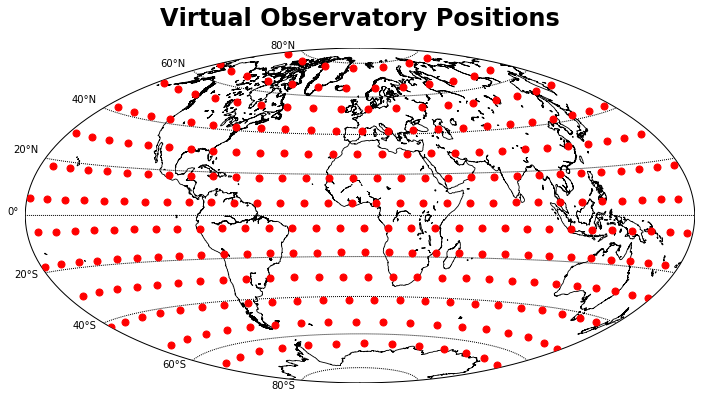

In [44]:
 # basemap plotting, check basemap documentation,
plt.figure(figsize=(12, 10))
ax = plt.gca()
m = Basemap(projection='hammer', resolution='l', area_thresh=1000.0,
            lat_0=-2, lon_0=0)

m.drawcoastlines(linewidth=0.85)
m.drawparallels(np.arange(-80, 81, 20), labels=[1, 0, 0, 0])

x,y = m(phi * 180/np.pi, theta * 180/np.pi - 90)
m.plot(x, y, 'ro', markersize=7)  # note to plot all points, remove "dropna" in loading function

title_string = ('Virtual Observatory Positions')
ttl = ax.title
ttl.set_position([.5, 1.05])

plt.title(title_string, fontsize=24, fontweight='bold')

plt.show()

We can also display the availability of data throughout the years:

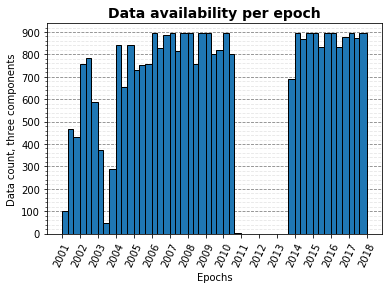

In [48]:
from lib import functions as ft

one_third_year = (1 - (12 - 4) / 12)
one_third_year = 0.3
epochs = [3, 7, 11]
tp = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
      2017]
file1 = '../data/VO_SWARM_MF_0101.txt'
file2 = '../data/VO_CHAMP_MF0101.txt'

count = []
tps = []
bins_tp = []
for y in tp:
    for e in epochs:
        [Br, Bt, Bp, theta, phi, r, errors] = ft.load_single_epoch(files=[file1, file2], year=y, epoch=e)

        n = len(Br) + len(Bt) + len(Bp)
        count.append(len(Br) + len(Bt) + len(Bp))

        # quantifying tp and append to list.
        if e == 3:
            tps.extend(list(np.repeat(y + 0 * one_third_year, n)))
            bins_tp.append(y + 0 * one_third_year)

        elif e == 7:
            tps.extend(list(np.repeat(y + 1 * one_third_year, n)))
            bins_tp.append(y + 1 * one_third_year)

        else:
            tps.extend(list(np.repeat(y + 2 * one_third_year, n)))
            bins_tp.append(y + 2 * one_third_year)

bins_tp.extend([2018.0])
counts, bins = np.histogram(tps, bins=len(tp)*len(epochs))
fig, ax = plt.subplots()
n, bins, patches = ax.hist(tps, bins=bins_tp, edgecolor='black')
ax.set_xlabel("Epochs", fontsize=10)
ax.set_ylabel("Data count, three components", fontsize=10)
plt.xticks(range(2001, 2019))
plt.yticks(range(0, 1000, 100))
ax.yaxis.grid(which='major', color='grey', linestyle='dashed')
ax.yaxis.grid(which='minor', color='gray', linestyle='dashed', alpha=0.2)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
plt.setp(ax.get_xticklabels(), rotation=65, horizontalalignment='center')
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=None,
                    wspace=None, hspace=None)
plt.title('Data availability per epoch', fontsize=14, fontweight='bold')
plt.show()